In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Conv2D, MaxPooling2D, Conv3D
from tensorflow import random
from keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
import os
import random

In [3]:
path1 = '/content/drive/MyDrive/Diabetes data time series/'
dc = os.path.join(path1,'finally_diabetes_data.csv')
diabetes = pd.read_csv(dc)
diabetes["Reg_ins_lag"] = diabetes["Reg_ins"].shift(1)
diabetes["NPH_ins_lag"] = diabetes["NPH_ins"].shift(1)
diabetes["min_glu_lag"] = diabetes["min_glu"].shift(1)
diabetes["max_glu_lag"] = diabetes["max_glu"].shift(1)
diabetes = diabetes.iloc[1:,:]
diabetes.head()

,date,case,Reg_ins,NPH_ins,min_glu,max_glu,Reg_ins_lag,NPH_ins_lag,min_glu_lag,max_glu_lag
1,4/22/1991,1,6.333333,13.0,211.0,294.0,8.000000,13.0,54.0,119.0
2,4/23/1991,1,9.000000,13.0,129.0,257.0,6.333333,13.0,211.0,294.0
3,4/24/1991,1,6.333333,14.0,129.0,239.0,9.000000,13.0,129.0,257.0
4,4/25/1991,1,5.500000,14.0,67.0,206.0,6.333333,14.0,129.0,239.0
5,4/26/1991,1,7.000000,14.0,77.0,228.0,5.500000,14.0,67.0,206.0


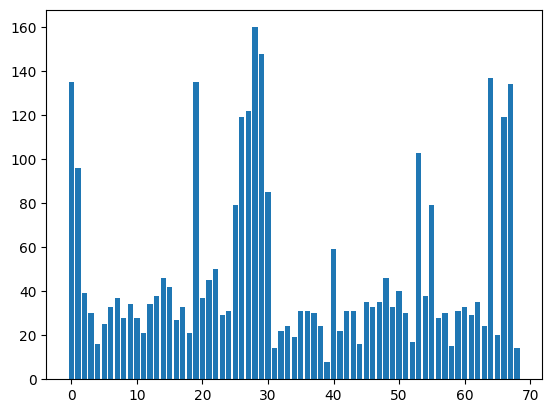

In [4]:
L = []
for i in range(1,70):
  L.append(list(diabetes['case']).count(i))
ax = plt.bar(np.arange(len(L)), L)
plt.show()

In [5]:
def split_to_seq(seq , gap , step):
  mat = np.zeros((step,round((len(seq)-step)/gap)))
  for i in range(0,len(seq)-step,gap):
    j = i + step
    new_row = seq[i:j]
    mat[:,i//gap] = new_row
  return mat

In [6]:
total = []
for i in ['Reg_ins' , 'NPH_ins' , 'min_glu' , 'max_glu', 'Reg_ins_lag' , 'NPH_ins_lag' , 'min_glu_lag' , 'max_glu_lag' ]:
  case_by_case_list = []
  for j in range(1,70):
    each_case_list = []
    a = diabetes[i][diabetes['case'] == j]
    each_case_list.append(a)
    case_by_case_list.append(each_case_list)
  total.append(case_by_case_list)
seq = []
for i in range(8):
  seq.append([])
  for j in range(69):
    seq[i].append(split_to_seq(total[i][j][0] , 1 , 5))
[len(seq),len(seq[0]),seq[0][0].shape]

[8, 69, (5, 130)]

In [7]:
train_data = []
test_data = []
for fold in range(3):
  train_data.append([])
  test_data.append([])
  idx = range(23*(fold-1)+1,23*fold+1)
  for i in range(8):
    train_data[fold].append(np.concatenate([seq[i][j] for j in range(69) if j not in idx],axis = 1))
    test_data[fold].append(np.concatenate([seq[i][j] for j in idx],axis = 1))
  train_data[fold] = np.array(train_data[fold])
  test_data[fold] = np.array(test_data[fold])
[train_data[0].shape, test_data[0].shape,train_data[1].shape, test_data[1].shape,train_data[2].shape, test_data[2].shape]

[(8, 5, 2828),
 (8, 5, 1090),
 (8, 5, 2149),
 (8, 5, 809),
 (8, 5, 1899),
 (8, 5, 1059)]

In [8]:
train_y0 = []
train_x0 = []
for fold in range(3):
  train_y0.append(np.zeros((train_data[fold].shape[2],5,2)))
  for i in range(train_data[fold].shape[2]):
    train_y0[fold][i,:,0] = train_data[fold][2,:,i]
    train_y0[fold][i,:,1] = train_data[fold][3,:,i]
  train_x0.append(np.zeros((train_data[fold].shape[2],5,2)))
  for i in range(train_data[fold].shape[2]):
    train_x0[fold][i,:,0] = train_data[fold][0,:,i]
    train_x0[fold][i,:,1] = train_data[fold][1,:,i]
[np.mean(train_y0[0][:,:,0]),np.mean(train_y0[0][:,:,1]),np.mean(train_x0[0][:,:,0]),np.mean(train_x0[0][:,:,1])]

[112.8632602545969, 223.17770509193775, 8.552277091765841, 20.19566831682065]

In [9]:
test_y0 = []
test_x0 = []
for fold in range(3):
  test_y0.append(np.zeros((test_data[fold].shape[2],5,2)))
  for i in range(test_data[fold].shape[2]):
    test_y0[fold][i,:,0] = test_data[fold][2,:,i]
    test_y0[fold][i,:,1] = test_data[fold][3,:,i]
  test_x0.append(np.zeros((test_data[fold].shape[2],5,2)))
  for i in range(test_data[fold].shape[2]):
    test_x0[fold][i,:,0] = test_data[fold][0,:,i]
    test_x0[fold][i,:,1] = test_data[fold][1,:,i]
[np.mean(test_y0[0][:,:,0]),np.mean(test_y0[0][:,:,1]),np.mean(test_x0[0][:,:,0]),np.mean(test_x0[0][:,:,1])]

[121.78243119266055, 244.2988990825688, 11.560198776813028, 24.719220183487156]

In [10]:
train_y1 = []
train_x1 = []
for fold in range(3):
  train_y1.append(np.zeros((train_data[fold].shape[2],2)))
  for i in range(train_data[fold].shape[2]):
    train_y1[fold][i,0] = train_data[fold][2,4,i]
    train_y1[fold][i,1] = train_data[fold][3,4,i]
  train_x1.append(np.zeros((train_data[fold].shape[2],5,6)))
  for i in range(train_data[fold].shape[2]):
    train_x1[fold][i,:,0] = train_data[fold][0,:,i]
    train_x1[fold][i,:,1] = train_data[fold][1,:,i]
    train_x1[fold][i,:,2] = train_data[fold][4,:,i]
    train_x1[fold][i,:,3] = train_data[fold][5,:,i]
    train_x1[fold][i,:,4] = train_data[fold][6,:,i]
    train_x1[fold][i,:,5] = train_data[fold][7,:,i]
[np.mean(train_y1[0][:,0]),np.mean(train_y1[0][:,1]),np.mean(train_x1[0][:,:,0]),np.mean(train_x1[0][:,:,1]),np.mean(train_x1[0][:,:,2]),np.mean(train_x1[0][:,:,3]),np.mean(train_x1[0][:,:,4]),np.mean(train_x1[0][:,:,5])]

[112.53076379066478,
 222.14444837340878,
 8.552277091765841,
 20.19566831682065,
 8.79595813844017,
 20.584429514364782,
 114.51550565770863,
 226.216973125884]

In [11]:
test_y1 = []
test_x1 = []
for fold in range(3):
  test_y1.append(np.zeros((test_data[fold].shape[2],2)))
  for i in range(test_data[fold].shape[2]):
    test_y1[fold][i,0] = test_data[fold][2,4,i]
    test_y1[fold][i,1] = test_data[fold][3,4,i]
  test_x1.append(np.zeros((test_data[fold].shape[2],5,6)))
  for i in range(test_data[fold].shape[2]):
    test_x1[fold][i,:,0] = test_data[fold][0,:,i]
    test_x1[fold][i,:,1] = test_data[fold][1,:,i]
    test_x1[fold][i,:,2] = test_data[fold][4,:,i]
    test_x1[fold][i,:,3] = test_data[fold][5,:,i]
    test_x1[fold][i,:,4] = test_data[fold][6,:,i]
    test_x1[fold][i,:,5] = test_data[fold][7,:,i]
[np.mean(test_y1[0][:,0]),np.mean(test_y1[0][:,1]),np.mean(test_x1[0][:,:,0]),np.mean(test_x1[0][:,:,1]),np.mean(test_x1[0][:,:,2]),np.mean(test_x1[0][:,:,3]),np.mean(test_x1[0][:,:,4]),np.mean(test_x1[0][:,:,5])]

[121.97683486238532,
 244.04311926605504,
 11.560198776813028,
 24.719220183487156,
 11.643149847151376,
 24.970779816506244,
 122.93532110091743,
 246.36733944954128]

In [12]:
miny0 = min([np.min(train_y0[0][:,:,0]),np.min(train_y0[1][:,:,0]),np.min(train_y0[2][:,:,0])])
maxy0 = max([np.max(train_y0[0][:,:,1]),np.max(train_y0[1][:,:,1]),np.max(train_y0[2][:,:,1])])
miny1 = min([np.min(train_y1[0][:,0]),np.min(train_y1[1][:,0]),np.min(train_y1[2][:,0])])
maxy1 = max([np.max(train_y1[0][:,1]),np.max(train_y1[1][:,1]),np.max(train_y1[2][:,1])])
[maxy0,miny0,maxy1,miny1]

[5926.0, 15.0, 3413.0, 15.0]

In [13]:
def output_restructure1(y):
  y_min = y[:,0]
  y_max = y[:,1]
  range = np.abs(y_max - y_min)+0.000001
  logmin = np.log(y_min)
  logrange = np.log(range)
  y[:,0] = logmin
  y[:,1] = logrange
  return y

In [14]:
def output_destructure1(y):
  y_logmin = y[:,0]
  y_logrange = y[:,1]
  range = np.exp(y_logrange-0.000001)
  y_min = np.exp(y_logmin)
  y_max = y_min + range
  if (y_min < miny1).all():
    y[:,0] = miny1
  else:
    y[:,0] = y_min
  if (y_max > maxy1).all():
    y[:,1] = maxy1
  else:
    y[:,1] = y_max
  return y

In [15]:
def output_restructure0(y):
  y_min = y[:,:,0]
  y_max = y[:,:,1]
  range = np.abs(y_max - y_min)+0.000001
  logmin = np.log(y_min)
  logrange = np.log(range)
  y[:,:,0] = logmin
  y[:,:,1] = logrange
  return y

In [16]:
def output_destructure0(y):
  y_logmin = y[:,:,0]
  y_logrange = y[:,:,1]
  range = np.exp(y_logrange-0.000001)
  y_min = np.exp(y_logmin)
  y_max = y_min + range
  if (y_min < miny0).all():
    y[:,:,0] = miny0
  else:
    y[:,:,0] = y_min
  if (y_max > maxy0).all():
    y[:,:,1] = maxy0
  else:
    y[:,:,1] = y_max
  return y

In [17]:
for fold in range(3):
  train_y0[fold] = output_restructure0(train_y0[fold])
  train_y1[fold] = output_restructure1(train_y1[fold])
  #test_y0[fold] = output_restructure0(test_y0[fold])
  #test_y1[fold] = output_restructure1(test_y1[fold])

In [18]:
[np.mean(train_y0[0][:,:,0]),np.mean(train_y0[0][:,:,1]),np.mean(test_y0[0][:,:,0]),np.mean(test_y0[0][:,:,1])]

[4.56673823571609, 4.4328862044637845, 4.579428078231301, 4.534633191219433]

In [25]:
model1 = []
for fold in range(3):
  model1.append(Sequential())
  model1[fold].add(LSTM(units = 2, input_shape=(5,2), return_sequences=True, activation = "relu"))
  model1[fold].add(LSTM(units = 2, input_shape=(5,2), return_sequences=True, activation = "linear"))
  model1[fold].compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
summary = model1[0].summary()
print(summary)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 2)              40        
                                                                 
 lstm_7 (LSTM)               (None, 5, 2)              40        
                                                                 
Total params: 80 (320.00 Byte)
Trainable params: 80 (320.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


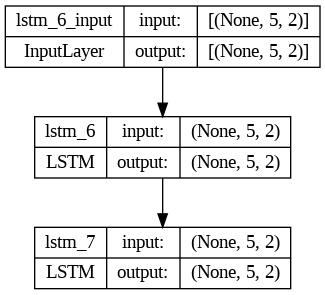

In [26]:
keras.utils.plot_model(model1[0], show_shapes=True)

In [27]:
for fold in range(3):
  model1[fold].fit(train_x0[fold], train_y0[fold], epochs=100, batch_size=16, verbose=2)

Epoch 1/100
177/177 - 3s - loss: 20.0691 - accuracy: 0.5231 - 3s/epoch - 17ms/step
Epoch 2/100
177/177 - 1s - loss: 16.2190 - accuracy: 0.5315 - 806ms/epoch - 5ms/step
Epoch 3/100
177/177 - 1s - loss: 8.3921 - accuracy: 0.4966 - 827ms/epoch - 5ms/step
Epoch 4/100
177/177 - 1s - loss: 3.9395 - accuracy: 0.4861 - 1s/epoch - 6ms/step
Epoch 5/100
177/177 - 1s - loss: 2.3235 - accuracy: 0.4924 - 1s/epoch - 7ms/step
Epoch 6/100
177/177 - 1s - loss: 1.5926 - accuracy: 0.4993 - 1s/epoch - 7ms/step
Epoch 7/100
177/177 - 1s - loss: 1.2536 - accuracy: 0.5078 - 1s/epoch - 6ms/step
Epoch 8/100
177/177 - 1s - loss: 1.0744 - accuracy: 0.5249 - 853ms/epoch - 5ms/step
Epoch 9/100
177/177 - 1s - loss: 0.9438 - accuracy: 0.5327 - 825ms/epoch - 5ms/step
Epoch 10/100
177/177 - 1s - loss: 0.8484 - accuracy: 0.5387 - 826ms/epoch - 5ms/step
Epoch 11/100
177/177 - 1s - loss: 0.7662 - accuracy: 0.5412 - 842ms/epoch - 5ms/step
Epoch 12/100
177/177 - 1s - loss: 0.6918 - accuracy: 0.5528 - 829ms/epoch - 5ms/step
E

In [28]:
y_pred01 =[]
for fold in range(3):
  y_pred01.append(model1[fold].predict(test_x0[fold]))

34/34 [==============================] - 1s 3ms/step


In [29]:
for fold in range(3):
  y_pred01[fold] = output_destructure0(y_pred01[fold])
  #test_y0[fold] = output_destructure0(test_y0[fold])

In [30]:
CV10 = 0
for fold in range(3):
  CV10 = CV10 + np.sum((y_pred01[fold]-test_y0[fold])**2)/math.prod(y_pred01[fold].shape)/3
CV10

17191.43339439429

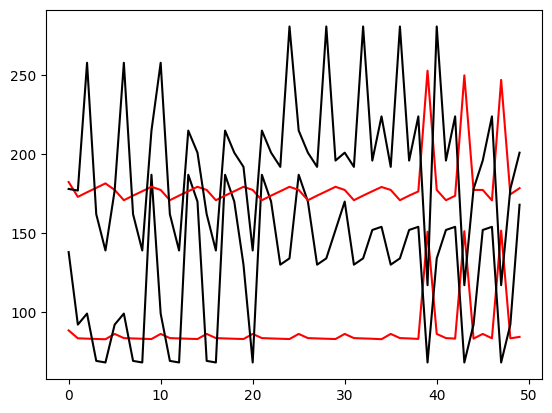

In [32]:
ii = random.randint(0, 800)
plt.plot(np.concatenate([y_pred01[2][jj,:,0] for jj in range(ii,(ii+10))]),color='red')
plt.plot(np.concatenate([test_y0[2][jj,:,0] for jj in range(ii,(ii+10))]),color='black')
plt.plot(np.concatenate([y_pred01[2][jj,:,1] for jj in range(ii,(ii+10))]),color='red')
plt.plot(np.concatenate([test_y0[2][jj,:,1] for jj in range(ii,(ii+10))]),color='black')
plt.show()

In [36]:
model2 = []
for fold in range(3):
  model2.append(Sequential())
  model2[fold].add(Reshape((5,2,1),input_shape=(5,2)))
  model2[fold].add(Conv2D(32,
    kernel_size=(2,2), input_shape=(5,2,1),
    strides=(1,1),
    padding="same",
  activation = "relu"))
  model2[fold].add(Reshape((5, 2, 32, 1)))
  model2[fold].add(Conv3D(1,
    kernel_size=(1,1,32),
    strides=(1, 1, 1),
    padding="valid",
  activation = "relu"))
  model2[fold].add(Reshape((5, 2)))
  model2[fold].compile(optimizer='adam', loss='mean_squared_error')
model2[0].summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_9 (Reshape)         (None, 5, 2, 1)           0         
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 2, 32)          160       
                                                                 
 reshape_10 (Reshape)        (None, 5, 2, 32, 1)       0         
                                                                 
 conv3d_3 (Conv3D)           (None, 5, 2, 1, 1)        33        
                                                                 
 reshape_11 (Reshape)        (None, 5, 2)              0         
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193 (772.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


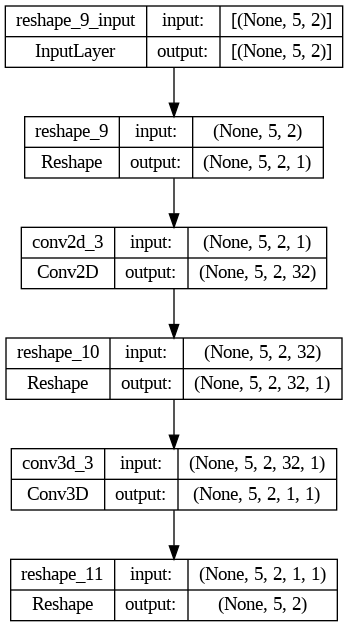

In [37]:
keras.utils.plot_model(model2[0], show_shapes=True)

In [38]:
for fold in range(3):
  model2[fold].fit(train_x0[fold], train_y0[fold], epochs=100, batch_size=20, verbose=2)

Epoch 1/100
142/142 - 1s - loss: 12.1505 - 1s/epoch - 11ms/step
Epoch 2/100
142/142 - 1s - loss: 8.2206 - 1s/epoch - 8ms/step
Epoch 3/100
142/142 - 1s - loss: 5.8321 - 1s/epoch - 8ms/step
Epoch 4/100
142/142 - 1s - loss: 4.1190 - 1s/epoch - 8ms/step
Epoch 5/100
142/142 - 1s - loss: 2.7988 - 863ms/epoch - 6ms/step
Epoch 6/100
142/142 - 1s - loss: 1.8403 - 704ms/epoch - 5ms/step
Epoch 7/100
142/142 - 1s - loss: 1.2074 - 712ms/epoch - 5ms/step
Epoch 8/100
142/142 - 1s - loss: 0.8582 - 702ms/epoch - 5ms/step
Epoch 9/100
142/142 - 1s - loss: 0.7146 - 707ms/epoch - 5ms/step
Epoch 10/100
142/142 - 1s - loss: 0.6186 - 712ms/epoch - 5ms/step
Epoch 11/100
142/142 - 1s - loss: 0.5779 - 730ms/epoch - 5ms/step
Epoch 12/100
142/142 - 1s - loss: 0.5498 - 729ms/epoch - 5ms/step
Epoch 13/100
142/142 - 1s - loss: 0.5257 - 670ms/epoch - 5ms/step
Epoch 14/100
142/142 - 1s - loss: 0.5059 - 718ms/epoch - 5ms/step
Epoch 15/100
142/142 - 1s - loss: 0.4778 - 697ms/epoch - 5ms/step
Epoch 16/100
142/142 - 1s - l

In [39]:
y_pred02 =[]
for fold in range(3):
  y_pred02.append(model2[fold].predict(test_x0[fold]))
  y_pred02[fold] = output_destructure0(y_pred02[fold])
CV20 = 0
for fold in range(3):
  CV20 = CV20 + np.sum((y_pred02[fold]-test_y0[fold])**2)/math.prod(y_pred02[fold].shape)/3
CV20

34/34 [==============================] - 0s 2ms/step


224293122.56010023

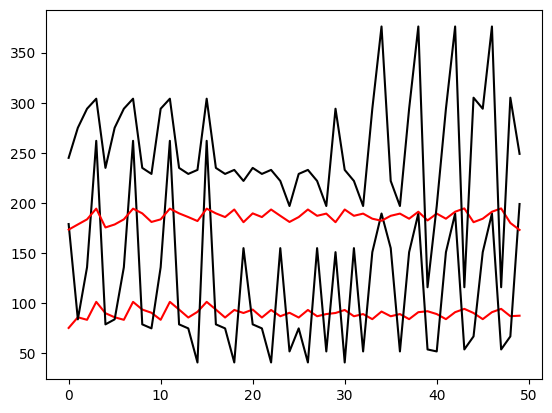

In [40]:
ii = random.randint(0, 1000)
plt.plot(np.concatenate([y_pred02[0][jj,:,0] for jj in range(ii,(ii+10))]),color='red')
plt.plot(np.concatenate([test_y0[0][jj,:,0] for jj in range(ii,(ii+10))]),color='black')
plt.plot(np.concatenate([y_pred02[0][jj,:,1] for jj in range(ii,(ii+10))]),color='red')
plt.plot(np.concatenate([test_y0[0][jj,:,1] for jj in range(ii,(ii+10))]),color='black')
plt.show()

In [41]:
model3 = []
for fold in range(3):
  model3.append(Sequential())
  model3[fold].add(LSTM(units = 2, input_shape=(5,6), return_sequences=True, activation = "relu"))
  model3[fold].add(LSTM(units = 2, return_sequences=False, activation = "linear"))
  model3[fold].compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
summary = model3[0].summary()
print(summary)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 2)              72        
                                                                 
 lstm_13 (LSTM)              (None, 2)                 40        
                                                                 
Total params: 112 (448.00 Byte)
Trainable params: 112 (448.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


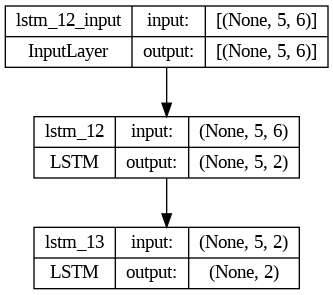

In [42]:
keras.utils.plot_model(model3[0], show_shapes=True)

In [43]:
for fold in range(3):
  model3[fold].fit(train_x1[fold], train_y1[fold], epochs=100, batch_size=16, verbose=2)

Epoch 1/100
177/177 - 4s - loss: 31.5752 - accuracy: 0.5014 - 4s/epoch - 22ms/step
Epoch 2/100
177/177 - 1s - loss: 25.7060 - accuracy: 0.4848 - 1s/epoch - 7ms/step
Epoch 3/100
177/177 - 1s - loss: 17.6571 - accuracy: 0.4837 - 1s/epoch - 8ms/step
Epoch 4/100
177/177 - 1s - loss: 7.8308 - accuracy: 0.4834 - 1s/epoch - 7ms/step
Epoch 5/100
177/177 - 1s - loss: 3.3487 - accuracy: 0.4781 - 811ms/epoch - 5ms/step
Epoch 6/100
177/177 - 1s - loss: 2.0749 - accuracy: 0.5216 - 848ms/epoch - 5ms/step
Epoch 7/100
177/177 - 1s - loss: 1.4870 - accuracy: 0.5244 - 833ms/epoch - 5ms/step
Epoch 8/100
177/177 - 1s - loss: 0.8946 - accuracy: 0.5262 - 883ms/epoch - 5ms/step
Epoch 9/100
177/177 - 1s - loss: 0.6456 - accuracy: 0.5244 - 885ms/epoch - 5ms/step
Epoch 10/100
177/177 - 1s - loss: 0.5352 - accuracy: 0.5240 - 891ms/epoch - 5ms/step
Epoch 11/100
177/177 - 1s - loss: 0.4958 - accuracy: 0.5244 - 904ms/epoch - 5ms/step
Epoch 12/100
177/177 - 1s - loss: 0.4723 - accuracy: 0.5230 - 872ms/epoch - 5ms/st

In [44]:
y_pred11 =[]
for fold in range(3):
  y_pred11.append(model3[fold].predict(test_x1[fold]))
  y_pred11[fold] = output_destructure1(y_pred11[fold])
  test_y1[fold] = output_destructure1(test_y1[fold])
CV11 = 0
for fold in range(3):
  CV11 = CV11 + np.sum((y_pred11[fold]-test_y1[fold])**2)/math.prod(y_pred11[fold].shape)/3
CV11

34/34 [==============================] - 1s 3ms/step


15612.009334085233

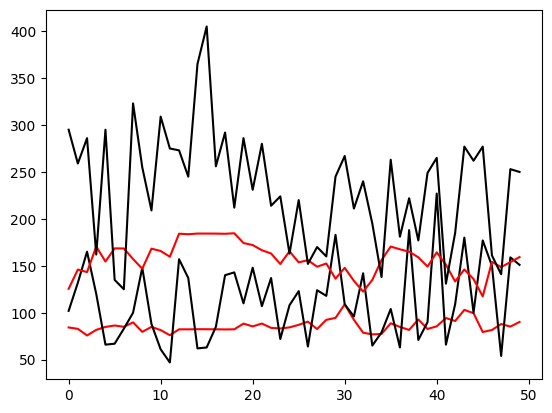

In [52]:
ii = random.randint(0, 1000)
plt.plot(np.hstack([y_pred11[0][jj,0] for jj in range(ii,(ii+50))]),color='red')
plt.plot(np.hstack([test_y1[0][jj,0] for jj in range(ii,(ii+50))]),color='black')
plt.plot(np.hstack([y_pred11[0][jj,1] for jj in range(ii,(ii+50))]),color='red')
plt.plot(np.hstack([test_y1[0][jj,1] for jj in range(ii,(ii+50))]),color='black')
plt.show()

In [59]:
model4 = []
for fold in range(3):
  model4.append(Sequential())
  model4[fold].add(Reshape((5,6,1),input_shape=(5,6)))
  model4[fold].add(Conv2D(32,
    kernel_size=(4,3), input_shape=(5,6,1),
    strides=(1,1),
    padding="valid",
  activation = "relu"))
  model4[fold].add(Reshape((2, 4, 32, 1)))
  model4[fold].add(Conv3D(1,
    kernel_size=(1,1,32),
    strides=(1, 1, 1),
    padding="valid",
  activation = "relu"))
  model4[fold].add(Reshape((2, 4, 1)))
  model4[fold].add(Conv2D(16,
    kernel_size=(2,3), input_shape=(2,4,1),
    strides=(1,1),
    padding="valid",
  activation = "relu"))
  model4[fold].add(Reshape((1, 2, 16, 1)))
  model4[fold].add(Conv3D(1,
    kernel_size=(1,1,16),
    strides=(1, 1, 1),
    padding="valid",
  activation = "relu"))
  model4[fold].add(Reshape([2]))
  model4[fold].compile(optimizer='adam', loss='mean_squared_error')
model4[0].summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_48 (Reshape)        (None, 5, 6, 1)           0         
                                                                 
 conv2d_18 (Conv2D)          (None, 2, 4, 32)          416       
                                                                 
 reshape_49 (Reshape)        (None, 2, 4, 32, 1)       0         
                                                                 
 conv3d_18 (Conv3D)          (None, 2, 4, 1, 1)        33        
                                                                 
 reshape_50 (Reshape)        (None, 2, 4, 1)           0         
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 2, 16)          112       
                                                                 
 reshape_51 (Reshape)        (None, 1, 2, 16, 1)     

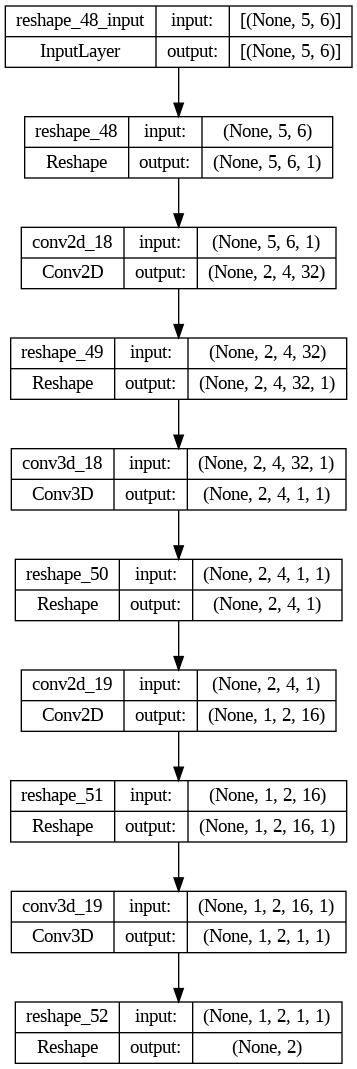

In [60]:
keras.utils.plot_model(model4[0], show_shapes=True)

In [61]:
for fold in range(3):
  model4[fold].fit(train_x1[fold], train_y1[fold], epochs=100, batch_size=20, verbose=2)

Epoch 1/100
142/142 - 3s - loss: 15.9995 - 3s/epoch - 18ms/step
Epoch 2/100
142/142 - 1s - loss: 4.7727 - 1s/epoch - 8ms/step
Epoch 3/100
142/142 - 1s - loss: 2.9415 - 786ms/epoch - 6ms/step
Epoch 4/100
142/142 - 1s - loss: 1.2927 - 735ms/epoch - 5ms/step
Epoch 5/100
142/142 - 1s - loss: 0.9364 - 715ms/epoch - 5ms/step
Epoch 6/100
142/142 - 1s - loss: 0.8044 - 741ms/epoch - 5ms/step
Epoch 7/100
142/142 - 1s - loss: 0.7350 - 725ms/epoch - 5ms/step
Epoch 8/100
142/142 - 1s - loss: 0.6585 - 727ms/epoch - 5ms/step
Epoch 9/100
142/142 - 1s - loss: 0.6361 - 719ms/epoch - 5ms/step
Epoch 10/100
142/142 - 1s - loss: 0.5932 - 696ms/epoch - 5ms/step
Epoch 11/100
142/142 - 1s - loss: 0.5571 - 727ms/epoch - 5ms/step
Epoch 12/100
142/142 - 1s - loss: 0.5479 - 735ms/epoch - 5ms/step
Epoch 13/100
142/142 - 1s - loss: 0.5132 - 702ms/epoch - 5ms/step
Epoch 14/100
142/142 - 1s - loss: 0.5051 - 708ms/epoch - 5ms/step
Epoch 15/100
142/142 - 1s - loss: 0.4877 - 691ms/epoch - 5ms/step
Epoch 16/100
142/142 - 

In [62]:
y_pred12 =[]
for fold in range(3):
  y_pred12.append(model4[fold].predict(test_x1[fold]))
  y_pred12[fold] = output_destructure1(y_pred12[fold])
CV12 = 0
for fold in range(3):
  CV12 = CV12 + np.sum((y_pred12[fold]-test_y1[fold])**2)/math.prod(y_pred12[fold].shape)/3
CV12

34/34 [==============================] - 0s 2ms/step


6962.824798461948

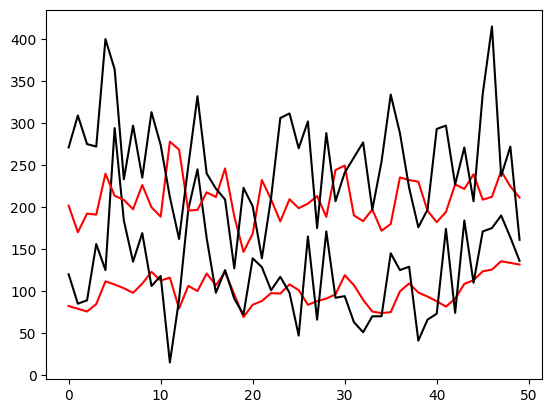

In [63]:
ii = random.randint(0, 1000)
plt.plot(np.hstack([y_pred12[0][jj,0] for jj in range(ii,(ii+50))]),color='red')
plt.plot(np.hstack([test_y1[0][jj,0] for jj in range(ii,(ii+50))]),color='black')
plt.plot(np.hstack([y_pred12[0][jj,1] for jj in range(ii,(ii+50))]),color='red')
plt.plot(np.hstack([test_y1[0][jj,1] for jj in range(ii,(ii+50))]),color='black')
plt.show()

In [64]:
def updowns1(y):
  oy = np.zeros(y.shape)
  y_min = y[:,0]
  y_max = y[:,1]
  difminsign = np.sign(np.diff(y_min))
  difmaxsign = np.sign(np.diff(y_max))
  oy[1:,0] = difminsign
  oy[1:,1] = difmaxsign
  return oy[1:,:]

In [65]:
def updowns0(y):
  oy = np.zeros(y.shape)
  y_min = y[:,:,0]
  y_max = y[:,:,1]
  difminsign = np.sign(np.diff(y_min))
  difmaxsign = np.sign(np.diff(y_max))
  oy[:,1:,0] = difminsign
  oy[:,1:,1] = difmaxsign
  return oy[:,1:,:]

In [66]:
CV11 = 0
for fold in range(3):
  CV11 = CV11 + np.sum(updowns1(y_pred11[fold]) == updowns1(test_y1[fold]))/np.prod(test_y1[fold].shape)/3
CV11

0.1296942698805716

In [67]:
CV12 = 0
for fold in range(3):
  CV12 = CV12 + np.sum(updowns1(y_pred12[fold]) == updowns1(test_y1[fold]))/np.prod(test_y1[fold].shape)/3
CV12

0.4369591589268327

In [68]:
CV01 = 0
for fold in range(3):
  CV01 = CV01 + np.sum(updowns0(y_pred01[fold]) == updowns0(test_y0[fold]))/np.prod(test_y0[fold].shape)/3
CV01

0.4273571866878365

In [69]:
CV02 = 0
for fold in range(3):
  CV02 = CV02 + np.sum(updowns0(y_pred02[fold]) == updowns0(test_y0[fold]))/np.prod(test_y0[fold].shape)/3
CV02

0.37579491465526865

In [73]:
def abnormal1(y):
  y_max = y[:,1]
  ab = [1*(y_max[j] > 180) for j in range(y_max.shape[0])]
  return ab

In [74]:
def abnormal0(y):
  y_max = y[:,:,1]
  ab = [[1*(y_max[j,k] > 180) for j in range(y_max.shape[0])] for k in range(y_max.shape[1])]
  return ab

In [96]:
np.sum(abnormal0(test_y0[fold]))

2942

In [82]:
np.sum(abnormal1(y_pred11[fold]))

1059

In [101]:
len(abnormal0(test_y0[0])[0])

1090

In [90]:
AB11 = 0
for fold in range(3):
  AB11 = AB11 + np.sum([abnormal1(y_pred11[fold])[j] == 1 and abnormal1(test_y1[fold])[j] == 1 for j in range(test_y1[fold].shape[0])])/np.sum(abnormal1(test_y1[fold]))/3
AB11

0.4828532235939643

In [92]:
AB12 = 0
for fold in range(3):
  AB12 = AB12 + np.sum([abnormal1(y_pred12[fold])[j] == 1 and abnormal1(test_y1[fold])[j] == 1 for j in range(test_y1[fold].shape[0])])/np.sum(abnormal1(test_y1[fold]))/3
AB12

0.7372742720749627

In [104]:
AB01 = 0
for fold in range(3):
  ab1 = abnormal0(y_pred01[fold])
  ab2 = abnormal0(test_y0[fold])
  AB01 = AB01 + np.sum([[ab1[j][k] == 1 and ab2[j][k] == 1 for j in range(test_y0[fold].shape[1])] for k in range(test_y0[fold].shape[0])])/np.sum(abnormal0(test_y0[fold]))/3
AB01

0.4524200704903564

In [105]:
AB02 = 0
for fold in range(3):
  ab1 = abnormal0(y_pred02[fold])
  ab2 = abnormal0(test_y0[fold])
  AB02 = AB02 + np.sum([[ab1[j][k] == 1 and ab2[j][k] == 1 for j in range(test_y0[fold].shape[1])] for k in range(test_y0[fold].shape[0])])/np.sum(abnormal0(test_y0[fold]))/3
AB02

0.6859016904415834